## Allianz Modelamiento No Supervisado
### Prueba Técnica para Científico de Datos
Norma Giraldo

In [1]:
# importar librerias
import numpy as np
import os
import sys
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

In [2]:
# adicionar directorio src a sys.path
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
# Ruta datos consolidados
data_path = "C:/Allianz/prueba_allianz/data/processed/allianz_consolidado_imputado.csv"

# Cargar datos consolidados
df_all = pd.read_csv(data_path, sep=";", encoding="utf-8", dtype=str)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   fecha_registro             684316 non-null  object
 1   comparison_id              684316 non-null  object
 2   edad                       684316 non-null  object
 3   ocupacion                  684316 non-null  object
 4   tipo_identificacion        684316 non-null  object
 5   genero                     684316 non-null  object
 6   fasecolda_id               684316 non-null  object
 7   marca                      684316 non-null  object
 8   referencia_vehiculo        684316 non-null  object
 9   tipo_caja                  684316 non-null  object
 10  valor_fasecolda            684316 non-null  object
 11  modelo                     684316 non-null  object
 12  dane_id                    684316 non-null  object
 13  ciudad                     684316 non-null  

In [4]:
from preprocessing import format_columns, clean_text_columns

# Formatea las columnas
df_all = format_columns(df_all)
# Depura textos en columnas
df_all = clean_text_columns(df_all)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684316 entries, 0 to 684315
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fecha_registro             684316 non-null  object 
 1   comparison_id              684316 non-null  object 
 2   edad                       684316 non-null  int64  
 3   ocupacion                  684316 non-null  object 
 4   tipo_identificacion        684316 non-null  object 
 5   genero                     684316 non-null  object 
 6   fasecolda_id               684316 non-null  object 
 7   marca                      684316 non-null  object 
 8   referencia_vehiculo        684316 non-null  object 
 9   tipo_caja                  684316 non-null  object 
 10  valor_fasecolda            684316 non-null  int64  
 11  modelo                     684316 non-null  int64  
 12  dane_id                    684316 non-null  object 
 13  ciudad                     68

In [5]:
bd_allianz_ = df_all.copy()

In [6]:
def remove_inconsistencies(df, key_columns):

    df_clean = df.drop_duplicates(subset=key_columns).copy()
    if 'valor_prima' in df_clean.columns:
        df_clean.drop(columns=['valor_prima'], inplace=True)
    return df_clean.reset_index(drop=True)

def calculate_average_premium(df, key_columns, average_column_name='valor_prima_promedio'):
    averages = df.groupby(key_columns)['valor_prima'].mean().reset_index()
    averages.rename(columns={'valor_prima': average_column_name}, inplace=True)
    return averages


key_columns = ['comparison_id', 'aseguradora_producto', 'perdida_total_cobertura', 'perdida_parcial_deducible']

clean_df = remove_inconsistencies(bd_allianz_, key_columns)
average_df = calculate_average_premium(bd_allianz_, key_columns)
final_df = clean_df.merge(average_df, on=key_columns, how='left')

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510766 entries, 0 to 510765
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   fecha_registro             510766 non-null  object 
 1   comparison_id              510766 non-null  object 
 2   edad                       510766 non-null  int64  
 3   ocupacion                  510766 non-null  object 
 4   tipo_identificacion        510766 non-null  object 
 5   genero                     510766 non-null  object 
 6   fasecolda_id               510766 non-null  object 
 7   marca                      510766 non-null  object 
 8   referencia_vehiculo        510766 non-null  object 
 9   tipo_caja                  510766 non-null  object 
 10  valor_fasecolda            510766 non-null  int64  
 11  modelo                     510766 non-null  int64  
 12  dane_id                    510766 non-null  object 
 13  ciudad                     51

In [8]:
def agrupar_modelo(modelo):
    """
    Clasifica el año del modelo del vehículo en grupos comerciales.

    Grupos:
    - Muy nuevo: 2022 en adelante
    - Reciente: 2018-2021
    - Medio: 2013-2017
    - Antiguo: menores que 2013
    """
    if modelo >= 2022:
        return 'G1_Muy nuevo (2022+)'
    elif modelo >= 2018:
        return 'G2_Reciente (2018-2021)'
    elif modelo >= 2013:
        return 'G3_Medio (2013-2017)'
    else:
        return 'G4_Antiguo (<=2012)'


def aplicar_grupo_modelo(df, columna_modelo='modelo', nueva_columna='grupo_modelo'):
    """
    Aplica la función de agrupación de modelo a un DataFrame y crea una nueva columna categórica.
    """
    df[nueva_columna] = df[columna_modelo].apply(agrupar_modelo)
    return df


In [9]:
final_df = aplicar_grupo_modelo(final_df)
final_df['grupo_modelo'].value_counts(normalize=True).mul(100).round(2)

grupo_modelo
G3_Medio (2013-2017)       32.90
G2_Reciente (2018-2021)    29.20
G1_Muy nuevo (2022+)       22.64
G4_Antiguo (<=2012)        15.26
Name: proportion, dtype: float64

In [10]:
def agrupar_edad(edad):
    if edad < 30:
        return 'G1_18-30'
    elif edad <= 35:
        return 'G2_31-35'
    elif edad <= 40:
        return 'G3_36-40'
    elif edad <= 50:
        return 'G4_41-50'
    elif edad <= 60:
        return 'G5_51-60'
    else:
        return 'G6_60+'

In [11]:
final_df['grupo_edad'] = final_df['edad'].apply(agrupar_edad)
final_df['grupo_edad'].value_counts(normalize=True).mul(100).round(2)

grupo_edad
G2_31-35    22.15
G4_41-50    21.67
G1_18-30    18.38
G3_36-40    15.18
G5_51-60    12.32
G6_60+      10.29
Name: proportion, dtype: float64

In [12]:
# frecuencia de marca
final_df['marca'].value_counts(normalize=True).mul(100).round(2)

marca
RENAULT          23.65
CHEVROLET        22.46
MAZDA            10.46
KIA               8.83
VOLKSWAGEN        7.35
NISSAN            6.59
SUZUKI            5.23
FORD              3.97
HYUNDAI           3.46
BMW               1.59
MERCEDES BENZ     1.45
TOYOTA            1.29
AUDI              0.58
FIAT              0.51
PEUGEOT           0.37
CITROEN           0.34
SEAT              0.32
HONDA             0.32
BYD               0.30
MINI              0.29
VOLVO             0.14
SKODA             0.10
MG                0.10
CHERY             0.07
MITSUBISHI        0.05
JAC               0.04
SUBARU            0.03
ZHIDOU            0.02
GREAT WALL        0.02
DS                0.01
JAGUAR            0.01
ALFA ROMEO        0.01
DAIHATSU          0.01
CHANGAN           0.00
GEELY             0.00
PORSCHE           0.00
CHANA             0.00
MAHINDRA          0.00
DAEWOO            0.00
LIFAN             0.00
BRILLIANCE        0.00
GAC               0.00
TESLA             0.00
BAIC 

In [13]:
# conservar solo las ciudades con mas del 2% de los registros

marcas_frecuentes = ['RENAULT', 'CHEVROLET', 'MAZDA', 'KIA', 'VOLKSWAGEN', 'NISSAN', 'SUZUKI', 'FORD', 'HYUNDAI', 'BMW', 'MERCEDES BENZ', 'TOYOTA']

# cambiar tipo a object para evitar problemas con el OneHotEncoder
final_df['marca'] = final_df['marca'].astype('object')
# Reemplazar por 'Otros' las ciudades que no están en la lista ciudades_frecuentes
final_df['marca'] = final_df['marca'].where(final_df['marca'].isin(marcas_frecuentes), 'Otras')
final_df['marca'].value_counts(normalize=True).mul(100).round(2)

marca
RENAULT          23.65
CHEVROLET        22.46
MAZDA            10.46
KIA               8.83
VOLKSWAGEN        7.35
NISSAN            6.59
SUZUKI            5.23
FORD              3.97
Otras             3.68
HYUNDAI           3.46
BMW               1.59
MERCEDES BENZ     1.45
TOYOTA            1.29
Name: proportion, dtype: float64

In [14]:
# frecuencia de ciudad
final_df['ciudad_dpto'].value_counts(normalize=True).mul(100).round(2)

ciudad_dpto
Bogotá D.C. - Bogotá D.C.    31.88
Medellin - Antioquia         13.69
Cali - Valle del Cauca       10.38
Barranquilla - Atlántico      4.06
Pereira - Risaralda           2.04
                             ...  
Bojaca - Cundinamarca         0.00
San Benito Abad - Sucre       0.00
Pensilvania - Caldas          0.00
Morales - Cauca               0.00
Colon - Nariño                0.00
Name: proportion, Length: 437, dtype: float64

In [15]:
# conservar solo las ciudades con mas del 2% de los registros
ciudades_frecuentes = ['Bogotá D.C. - Bogotá D.C.', 
                        'Medellin - Antioquia',
                        'Cali - Valle del Cauca',
                        'Barranquilla - Atlántico',
                        'Pereira - Risaralda']

# Reemplazar por 'Otros' las ciudades que no están en la lista ciudades_frecuentes
final_df['ciudad_dpto'] = final_df['ciudad_dpto'].where(final_df['ciudad_dpto'].isin(ciudades_frecuentes), 'Otros')
final_df['ciudad_dpto'].value_counts(normalize=True).mul(100).round(2)

ciudad_dpto
Otros                        37.95
Bogotá D.C. - Bogotá D.C.    31.88
Medellin - Antioquia         13.69
Cali - Valle del Cauca       10.38
Barranquilla - Atlántico      4.06
Pereira - Risaralda           2.04
Name: proportion, dtype: float64

In [16]:
final_df.columns

Index(['fecha_registro', 'comparison_id', 'edad', 'ocupacion',
       'tipo_identificacion', 'genero', 'fasecolda_id', 'marca',
       'referencia_vehiculo', 'tipo_caja', 'valor_fasecolda', 'modelo',
       'dane_id', 'ciudad', 'departamento_id', 'departamento',
       'vehiculo_nuevo', 'aseguradora_producto', 'cotizacion_fecha',
       'perdida_total_cobertura', 'perdida_parcial_deducible',
       'rce_limite_unico', 'emitido_producto', 'emitido_cotizacion',
       'source_file', 'delta_minutos', 'anio', 'mes', 'dia_semana', 'mes_anio',
       'aseguradora_origen', 'producto_origen', 'emitido', 'ciudad_dpto',
       'valor_prima_promedio', 'grupo_modelo', 'grupo_edad'],
      dtype='object')

### Asegurar tipos de variables

In [17]:
id_cols = ['comparison_id', 'fasecolda_id', 'dane_id', 'departamento_id'] 

# Eliminar columnas de id
for col in id_cols:
    if col in final_df.columns:
        final_df.drop(columns=[col], inplace=True)

dates_cols = ['fecha_registro', 'cotizacion_fecha', 'anio', 'mes', 'dia_semana', 'mes_anio', 'source_file']

# Eliminar columnas de fechas
for col in dates_cols:
    if col in final_df.columns:
        final_df.drop(columns=[col], inplace=True)

int_cols = ['edad', 'modelo', 'valor_fasecolda']

# configurar columnas de enteros
for col in int_cols:
    if col in final_df.columns:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce').astype('Int64')

float_cols = ['valor_prima_promedio']

# configurar columnas de flotantes
for col in float_cols:
    if col in final_df.columns:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce').astype('float64')

cat_cols = ['grupo_modelo', 'grupo_edad', 'ocupacion', 'genero', 'marca', 'referencia_vehiculo',
            'tipo_caja', 'ciudad_dpto', 'vehiculo_nuevo', 'aseguradora_producto',
            'perdida_total_cobertura', 'perdida_parcial_deducible', 'emitido_producto', 
            'aseguradora_origen', 'producto_origen', 'emitido']

# configurar columnas categoricas
for col in cat_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].astype('object')


bool_cols = ['rce_limite_unico', 'emitido_cotizacion']

# configurar columnas booleanas
for col in bool_cols:
    if col in final_df.columns:
        final_df[col] = final_df[col].astype('bool')

# Eliminar columnas redundantes
final_df.drop(columns=['modelo', 'edad', 'ciudad', 'departamento', 'tipo_identificacion','delta_minutos'], inplace=True)

# Verificar tipos de datos
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510766 entries, 0 to 510765
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ocupacion                  510766 non-null  object 
 1   genero                     510766 non-null  object 
 2   marca                      510766 non-null  object 
 3   referencia_vehiculo        510766 non-null  object 
 4   tipo_caja                  510766 non-null  object 
 5   valor_fasecolda            510766 non-null  Int64  
 6   vehiculo_nuevo             510766 non-null  object 
 7   aseguradora_producto       510766 non-null  object 
 8   perdida_total_cobertura    510766 non-null  object 
 9   perdida_parcial_deducible  510766 non-null  object 
 10  rce_limite_unico           510766 non-null  bool   
 11  emitido_producto           510766 non-null  object 
 12  emitido_cotizacion         510766 non-null  bool   
 13  aseguradora_origen         51

In [18]:
final_df.columns

Index(['ocupacion', 'genero', 'marca', 'referencia_vehiculo', 'tipo_caja',
       'valor_fasecolda', 'vehiculo_nuevo', 'aseguradora_producto',
       'perdida_total_cobertura', 'perdida_parcial_deducible',
       'rce_limite_unico', 'emitido_producto', 'emitido_cotizacion',
       'aseguradora_origen', 'producto_origen', 'emitido', 'ciudad_dpto',
       'valor_prima_promedio', 'grupo_modelo', 'grupo_edad'],
      dtype='object')

## Perfilamiento de Clientes

In [19]:
# Check data types and missing values
def evaluate_variables(df):
    # Get info for each column
    var_analysis = pd.DataFrame({
        'dtype': df.dtypes,
        'missing': df.isnull().sum(),
        'missing_pct': (df.isnull().sum() / len(df) * 100).round(2),
        'unique_values': df.nunique(),
        'unique_pct': (df.nunique() / len(df) * 100).round(2)
    })
    return var_analysis

var_analysis = evaluate_variables(final_df)
print("Variable Analysis:")
print(var_analysis)

Variable Analysis:
                             dtype  missing  missing_pct  unique_values  \
ocupacion                   object        0         0.00              7   
genero                      object        0         0.00              2   
marca                       object        0         0.00             13   
referencia_vehiculo         object        0         0.00           2124   
tipo_caja                   object        0         0.00              4   
valor_fasecolda              Int64        0         0.00           1377   
vehiculo_nuevo              object        0         0.00              2   
aseguradora_producto        object        0         0.00             60   
perdida_total_cobertura     object        0         0.00              2   
perdida_parcial_deducible   object        0         0.00              2   
rce_limite_unico              bool        0         0.00              2   
emitido_producto            object        0         0.00             55   
emitid

In [20]:
final_df.drop(columns=['aseguradora_origen', 'producto_origen'], inplace=True)

In [21]:
def analyze_categorical_vars(df):
    cat_cols = df.select_dtypes(include=['category', 'object']).columns
    
    for col in cat_cols:
        print(f"\nDistribution for {col}:")
        print(df[col].value_counts(normalize=True).mul(100).round(2))
        
def analyze_numeric_vars(df):
    num_cols = df.select_dtypes(include=['int64', 'float64', 'Int64']).columns
    
    print("\nNumeric Variables Summary:")
    print(df[num_cols].describe())

analyze_categorical_vars(final_df)
analyze_numeric_vars(final_df)


Distribution for ocupacion:
ocupacion
Estudiante       82.31
Empleado         14.58
Independiente     1.99
Inversionista     0.45
Pensionado        0.35
Rentista          0.28
Comerciante       0.05
Name: proportion, dtype: float64

Distribution for genero:
genero
Masculino    61.99
Femenino     38.01
Name: proportion, dtype: float64

Distribution for marca:
marca
RENAULT          23.65
CHEVROLET        22.46
MAZDA            10.46
KIA               8.83
VOLKSWAGEN        7.35
NISSAN            6.59
SUZUKI            5.23
FORD              3.97
Otras             3.68
HYUNDAI           3.46
BMW               1.59
MERCEDES BENZ     1.45
TOYOTA            1.29
Name: proportion, dtype: float64

Distribution for referencia_vehiculo:
referencia_vehiculo
SWIFT [4] DZIRE MT 1200CC 4P 2AB ABS (AUTOMOVIL)                   1.48
SWIFT [4] HYBRID MT 1200CC 5P 6AB ABS (AUTOMOVIL)                  1.23
SAIL LTZ MT 1400CC 4P AA 2AB ABS (AUTOMOVIL)                       1.10
KWID OUTSIDER MT 1000CC 1

In [22]:
final_df.drop(columns=['referencia_vehiculo'], inplace=True)

In [23]:
final_df.columns

Index(['ocupacion', 'genero', 'marca', 'tipo_caja', 'valor_fasecolda',
       'vehiculo_nuevo', 'aseguradora_producto', 'perdida_total_cobertura',
       'perdida_parcial_deducible', 'rce_limite_unico', 'emitido_producto',
       'emitido_cotizacion', 'emitido', 'ciudad_dpto', 'valor_prima_promedio',
       'grupo_modelo', 'grupo_edad'],
      dtype='object')

In [24]:
# predictoras = ['aseguradora_producto', 'emitido_producto', 'emitido_cotizacion', 'emitido']

In [25]:
# variables for segmentation
segmentation_vars = {
    'demographic': [
        'grupo_edad',          # Age groups
        'ocupacion',           # Occupation
        'genero',             # Gender
        'ciudad_dpto'         # City-Department
    ],
    'vehicle': [
        'grupo_modelo',        # Model group
        'marca',              # Brand
        'tipo_caja',          # Transmission type
        'valor_fasecolda',    # Vehicle value
        'vehiculo_nuevo'      # New/Used vehicle
    ],
    'product': [
        'perdida_total_cobertura',     # Total loss coverage
        'perdida_parcial_deducible',   # Partial loss deductible
        'rce_limite_unico',            # RCE unique limit
        'valor_prima_promedio'         # Average premium
    ]
}

In [26]:
# Definir variables relevantes para la segmentación
vars_segmentacion = [var for category in segmentation_vars.values() for var in category]

# Separar variables por tipo
cat_vars = [var for var in vars_segmentacion if final_df[var].dtype == 'category']
num_vars = [var for var in vars_segmentacion if final_df[var].dtype in ['int64', 'float64', 'Int64']]
bool_vars = [var for var in vars_segmentacion if final_df[var].dtype == 'bool']

# Preprocesamiento actualizado con tres tipos de variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars),
        ('bool', OneHotEncoder(drop='if_binary'), bool_vars)  # Procesamiento específico para booleanas
    ])

# Pipeline de clustering
kmeans_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clustering', KMeans(n_clusters=2, random_state=42))
])

# Aplicar clustering
final_df['cluster'] = kmeans_pipeline.fit_predict(final_df[vars_segmentacion])

### Análisis de Patrones de Emisión por Segmento

In [27]:
# Convertir la columna 'emitido' a tipo numérico para realizar operaciones de suma
final_df['emitido'] = final_df['emitido'].astype(int)

# Para cada cluster, analizar tasas de emisión por aseguradora y producto
perfil_emisiones = final_df.groupby(['cluster', 'aseguradora_producto'])['emitido'].agg(['count', 'sum', 'mean'])
perfil_emisiones = perfil_emisiones.rename(columns={'mean': 'tasa_emision'})
perfil_emisiones = perfil_emisiones.sort_values(['cluster', 'tasa_emision'], ascending=[True, False])

# Identificar las mejores opciones para cada cluster
mejores_opciones = perfil_emisiones.groupby('cluster').head(3)

In [28]:
mejores_opciones

count   sum  tasa_emision
cluster aseguradora_producto                                     
0       Aseguradora2_                    4303  1510      0.350918
        Aseguradora2_RCE                 2560   854      0.333594
        Aseguradora2_TodoRiesgoAlto      2719   889      0.326958
1       Aseguradora5_TodoRiesgoMedio      129    29      0.224806
        Aseguradora12_Todo Riesgo Bajo   1358   303      0.223122
        Aseguradora8_TodoRiesgoBajo       822   183      0.222628

### Caracterización de Perfiles con Reglas de Decisión

In [30]:
def extract_rules_from_tree(tree_model, preprocessor):
    """
    Extrae reglas interpretables de un árbol de decisión
    
    Args:
        tree_model: Modelo de árbol de decisión entrenado
        preprocessor: Preprocesador utilizado para transformar los datos
    
    Returns:
        Dictionary con reglas que caracterizan el perfil
    """
    # Obtener feature names después del preprocesamiento
    feature_names = preprocessor.get_feature_names_out()
    
    # Obtener estructura del árbol
    n_nodes = tree_model.tree_.node_count
    children_left = tree_model.tree_.children_left
    children_right = tree_model.tree_.children_right
    feature = tree_model.tree_.feature
    threshold = tree_model.tree_.threshold
    values = tree_model.tree_.value
    
    # Función para recorrer el árbol y extraer reglas
    def _get_rules_recursive(node_id, current_rules):
        # Si es nodo hoja, retornamos las reglas y la clase
        if children_left[node_id] == children_right[node_id]:  # Es un nodo hoja
            class_counts = values[node_id][0]
            predicted_class = class_counts.argmax()
            confidence = class_counts[predicted_class] / class_counts.sum()
            
            return current_rules, predicted_class, confidence
        
        # Obtenemos feature y threshold de este nodo
        feature_id = feature[node_id]
        threshold_value = threshold[node_id]
        feature_name = feature_names[feature_id] if feature_id != -2 else "Unknown"
        
        # Creamos reglas para rama izquierda (≤ threshold)
        left_rules = current_rules.copy()
        if "=" in feature_name:  # Característica one-hot codificada
            # Extraer nombre original de la feature y valor
            parts = feature_name.split("=")
            orig_feature = parts[0].replace("cat__", "")
            value = parts[1]
            
            if threshold_value > 0.5:  # Para one-hot encoding, threshold suele ser 0.5
                left_rules[orig_feature] = value
        else:  # Feature numérica
            feature_clean = feature_name.replace("num__", "")
            left_rules[feature_clean] = f"≤ {threshold_value:.2f}"
        
        # Creamos reglas para rama derecha (> threshold)
        right_rules = current_rules.copy()
        if "=" in feature_name:
            parts = feature_name.split("=")
            orig_feature = parts[0].replace("cat__", "")
            value = parts[1]
            
            if threshold_value > 0.5:
                right_rules[orig_feature + "_not"] = value  # Indicamos que no es este valor
        else:
            feature_clean = feature_name.replace("num__", "")
            right_rules[feature_clean] = f"> {threshold_value:.2f}"
        
        # Recursivamente procesamos las ramas izquierda y derecha
        left_result = _get_rules_recursive(children_left[node_id], left_rules)
        right_result = _get_rules_recursive(children_right[node_id], right_rules)
        
        # Retornamos los resultados dependiendo de cuál rama lleva a la clase 1 (perfil)
        if left_result[1] == 1 and left_result[2] > right_result[2]:
            return left_result
        else:
            return right_result
    
    # Iniciar la extracción de reglas desde la raíz
    rules, predicted_class, confidence = _get_rules_recursive(0, {})
    # Formatear las reglas para una mejor presentación
    formatted_rules = {k: v for k, v in rules.items() if k not in ["Unknown", "Unknown_not"]}
    formatted_rules['predicted_class'] = predicted_class
    formatted_rules['confidence'] = confidence
    
    return formatted_rules

In [31]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Para cada cluster, entrenar un modelo de árbol de decisión para describir el perfil
perfiles_caracterizados = {}

for cluster_id in final_df['cluster'].unique():
    # Seleccionar datos del cluster
    cluster_data = final_df[final_df['cluster'] == cluster_id]
    
    # Crear variable binaria para este cluster vs. resto
    y_cluster = (final_df['cluster'] == cluster_id).astype(int)
    
    # Entrenar árbol de decisión para caracterizar el cluster
    tree_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)
    tree_model.fit(preprocessor.fit_transform(final_df[vars_segmentacion]), y_cluster)
    
    # Extraer reglas del árbol para caracterizar el perfil
    perfiles_caracterizados[cluster_id] = extract_rules_from_tree(tree_model, preprocessor)

### Refinamiento con Análisis por Subgrupos

In [32]:
final_df.columns

Index(['ocupacion', 'genero', 'marca', 'tipo_caja', 'valor_fasecolda',
       'vehiculo_nuevo', 'aseguradora_producto', 'perdida_total_cobertura',
       'perdida_parcial_deducible', 'rce_limite_unico', 'emitido_producto',
       'emitido_cotizacion', 'emitido', 'ciudad_dpto', 'valor_prima_promedio',
       'grupo_modelo', 'grupo_edad', 'cluster'],
      dtype='object')

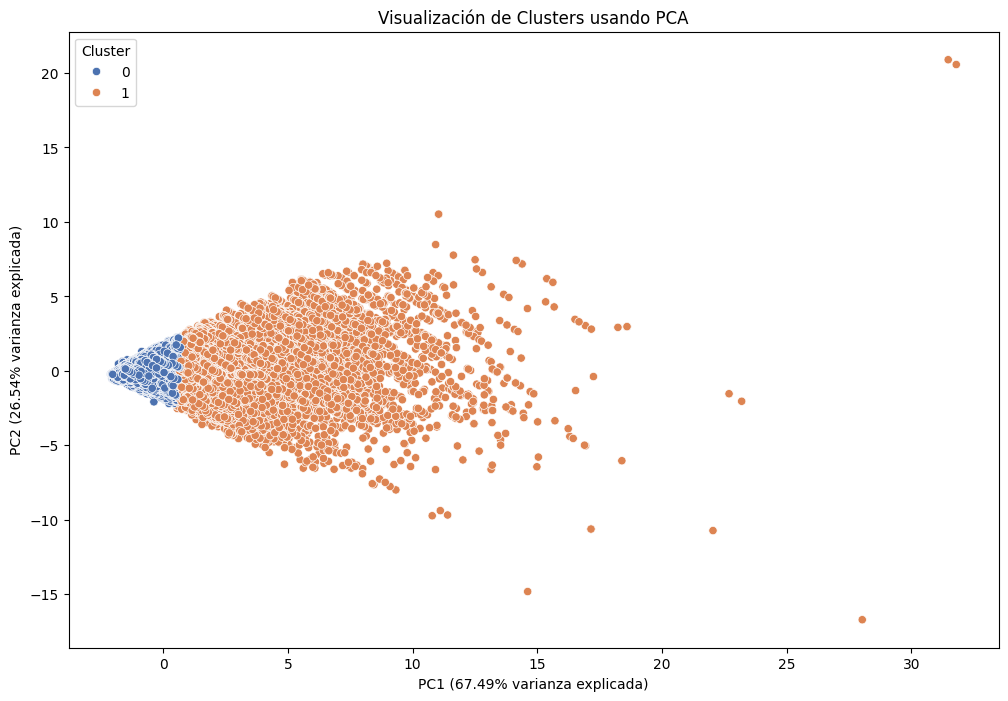

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener datos transformados
X_transformed = preprocessor.fit_transform(final_df[vars_segmentacion])

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Crear DataFrame para visualización
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['Cluster'] = final_df['cluster']

# Crear gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
plt.title('Visualización de Clusters usando PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza explicada)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza explicada)')
plt.show()

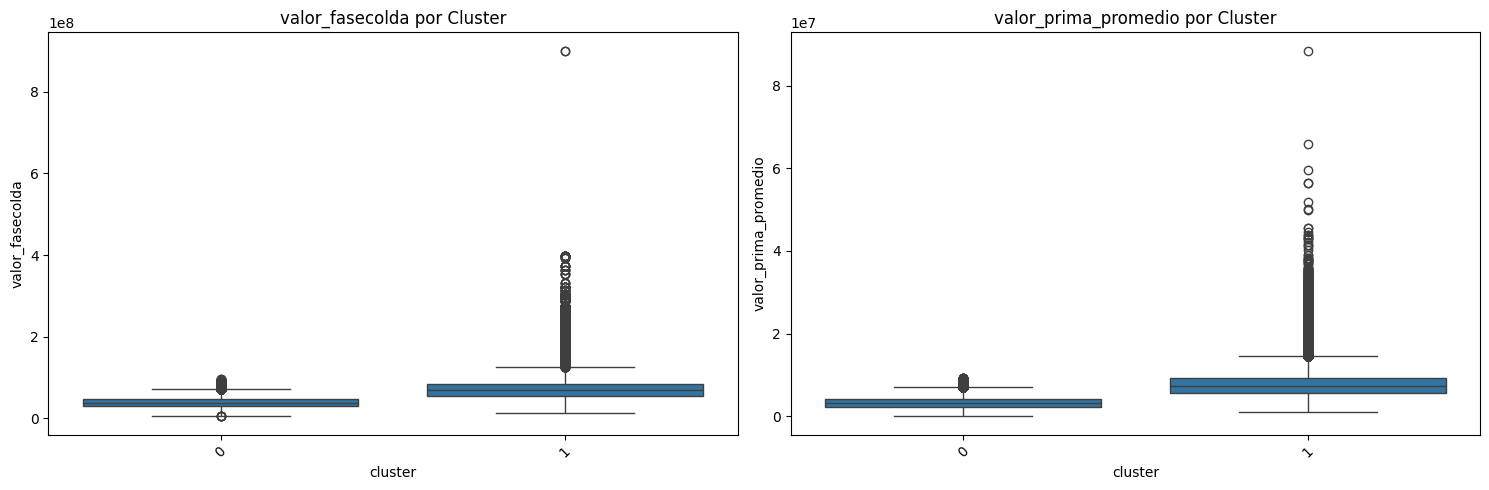

In [35]:
# Visualizar distribución de variables numéricas por cluster
fig, axes = plt.subplots(1, len(num_vars), figsize=(15, 5))
for i, var in enumerate(num_vars):
    sns.boxplot(data=final_df, x='cluster', y=var, ax=axes[i])
    axes[i].set_title(f'{var} por Cluster')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

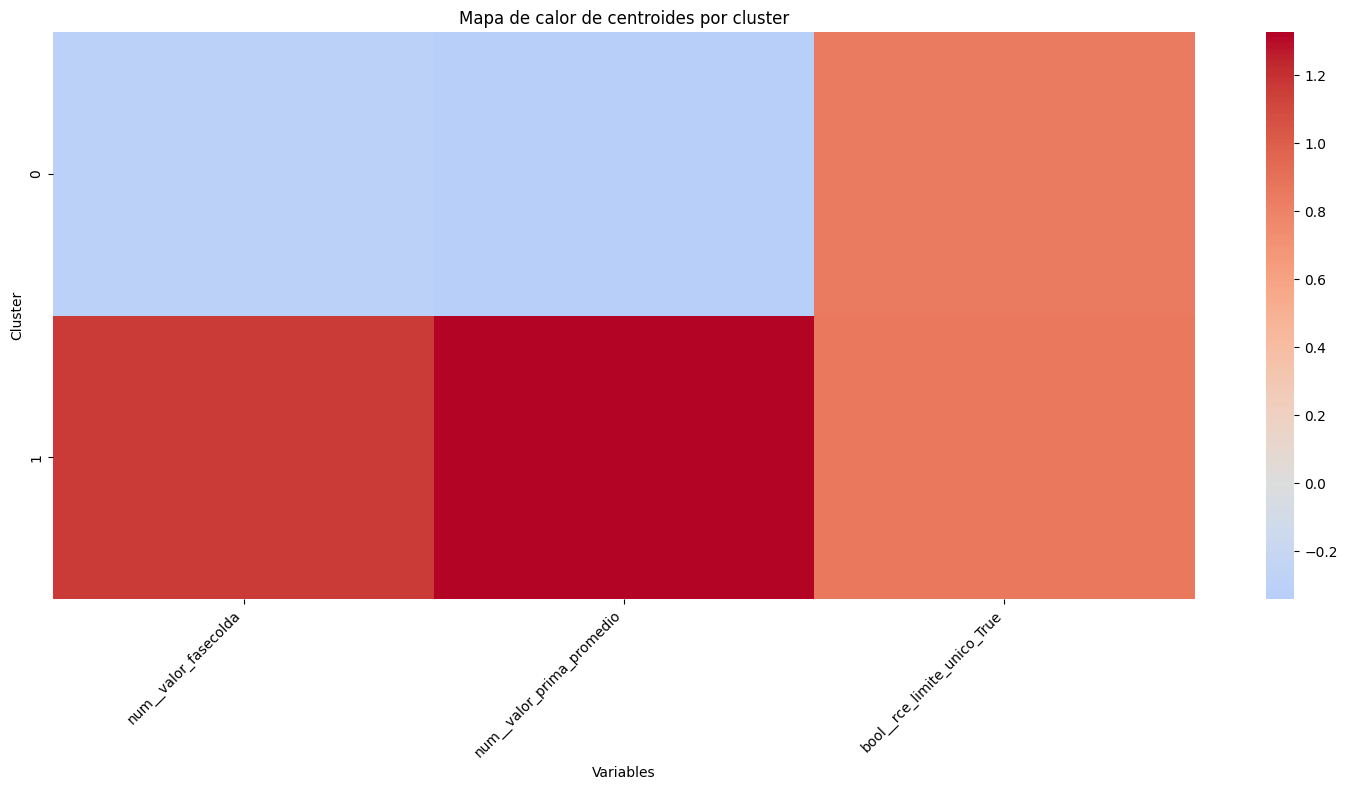

In [36]:
# Obtener centroides de cada cluster
cluster_centers = pd.DataFrame(
    kmeans_pipeline.named_steps['clustering'].cluster_centers_,
    columns=preprocessor.get_feature_names_out()
)

# Crear mapa de calor
plt.figure(figsize=(15, 8))
sns.heatmap(cluster_centers, cmap='coolwarm', center=0)
plt.title('Mapa de calor de centroides por cluster')
plt.xlabel('Variables')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.sparse import csr_matrix

# Crear tabla binaria para reglas de asociación usando las mismas variables de segmentación
selected_columns = [
    # Variables demográficas
    'grupo_edad', 'ocupacion', 'genero', 'ciudad_dpto',
    # Variables del vehículo
    #'grupo_modelo', 'marca', 'tipo_caja', 'vehiculo_nuevo',
    #'grupo_modelo', 'tipo_caja', 'vehiculo_nuevo',
    # Variables del producto
    'perdida_total_cobertura', 'perdida_parcial_deducible', 'rce_limite_unico',
    # Variable objetivo para reglas de asociación
    'aseguradora_producto', 'emitido'
]
df_binary = pd.get_dummies(final_df[selected_columns], sparse=True)

# Filtrar solo registros emitidos
df_emitidos = df_binary[df_binary['emitido'] == 1].drop(columns=['emitido'])

# Convertir a matriz dispersa para ahorrar memoria
df_emitidos_sparse = csr_matrix(df_emitidos.values)

# Encontrar patrones frecuentes con un soporte mínimo más alto para reducir memoria
frequent_itemsets = apriori(pd.DataFrame.sparse.from_spmatrix(df_emitidos_sparse, columns=df_emitidos.columns),
                            min_support=0.05, use_colnames=True)

# Generar reglas de asociación
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

# Filtrar reglas relevantes (donde producto/aseguradora está en el consecuente)
product_rules = rules[rules['consequents'].apply(
    lambda x: any('aseguradora_producto' in item for item in x)
)]

C:\Users\norma\AppData\Local\Temp\ipykernel_29064\1190505293.py:25: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  frequent_itemsets = apriori(pd.DataFrame.sparse.from_spmatrix(df_emitidos_sparse, columns=df_emitidos.columns),


### Integración de Múltiples Perspectivas

In [39]:
# Combinar los insights de clustering y reglas de asociación
perfiles_integrados = []

for cluster_id, perfil_rules in perfiles_caracterizados.items():
    # Obtener mejores opciones para este cluster
    opciones = mejores_opciones.loc[cluster_id].reset_index().copy()
    
    # Combinar con reglas de asociación relevantes
    reglas_relevantes = product_rules[product_rules['antecedents'].apply(
        lambda x: any(item in perfil_rules for item in x))]
    
    # Crear descripción integrada del perfil
    perfil_integrado = {
        'id_perfil': cluster_id,
        'descripcion': perfil_rules,
        'mejores_opciones': opciones['aseguradora_producto'].tolist(),
        'tasa_conversion': opciones['tasa_emision'].tolist(),
        'reglas_asociacion': reglas_relevantes.to_dict() if not reglas_relevantes.empty else None
    }
    
    perfiles_integrados.append(perfil_integrado)

### Generación de Descripciones en Lenguaje Natural

In [40]:
# Función para convertir reglas técnicas en descripciones legibles
def generar_descripcion_perfil(perfil):
    # Extraer características clave
    caract = perfil['descripcion']
    
    # Construir descripción en lenguaje natural
    descripcion = f"Perfil de clientes que son "
    
    if 'genero' in caract:
        descripcion += f"{caract['genero']} "
    
    if 'rango_edad' in caract:
        descripcion += f"entre {caract['rango_edad']} años "
    
    if 'ocupacion' in caract:
        descripcion += f"de ocupación {caract['ocupacion']} "
    
    if 'ciudad' in caract:
        descripcion += f"de la ciudad de {caract['ciudad']} "
    
    if 'marca' in caract:
        descripcion += f"que tienen vehículos {caract['marca']} "
    
    if 'referencia_vehiculo' in caract:
        descripcion += f"{caract['referencia_vehiculo']} "
    
    # Añadir recomendación
    mejor_opcion = perfil['mejores_opciones'][0]
    tasa = perfil['tasa_conversion'][0]
    
    descripcion += f", es probable que encuentren una mejor oferta en {mejor_opcion} "
    descripcion += f"con una tasa de conversión de {tasa:.2%}"
    
    return descripcion

# Generar descripciones para todos los perfiles
for perfil in perfiles_integrados:
    perfil['descripcion_legible'] = generar_descripcion_perfil(perfil)

### Validación con Análisis de Lift y Soporte

In [42]:
# Para cada perfil, validar si realmente tiene mejor desempeño que la población general
for perfil in perfiles_integrados:
    # Calcular tasa de emisión promedio para la mejor opción en la población general
    producto = perfil['mejores_opciones'][0]
    tasa_general = final_df[final_df['aseguradora_producto'] == producto]['emitido'].mean()
    
    # Calcular lift
    lift = perfil['tasa_conversion'][0] / tasa_general
    
    # Añadir métricas de validación
    perfil['lift'] = lift
    perfil['significancia'] = 'Alta' if lift > 1.5 else 'Media' if lift > 1.2 else 'Baja'

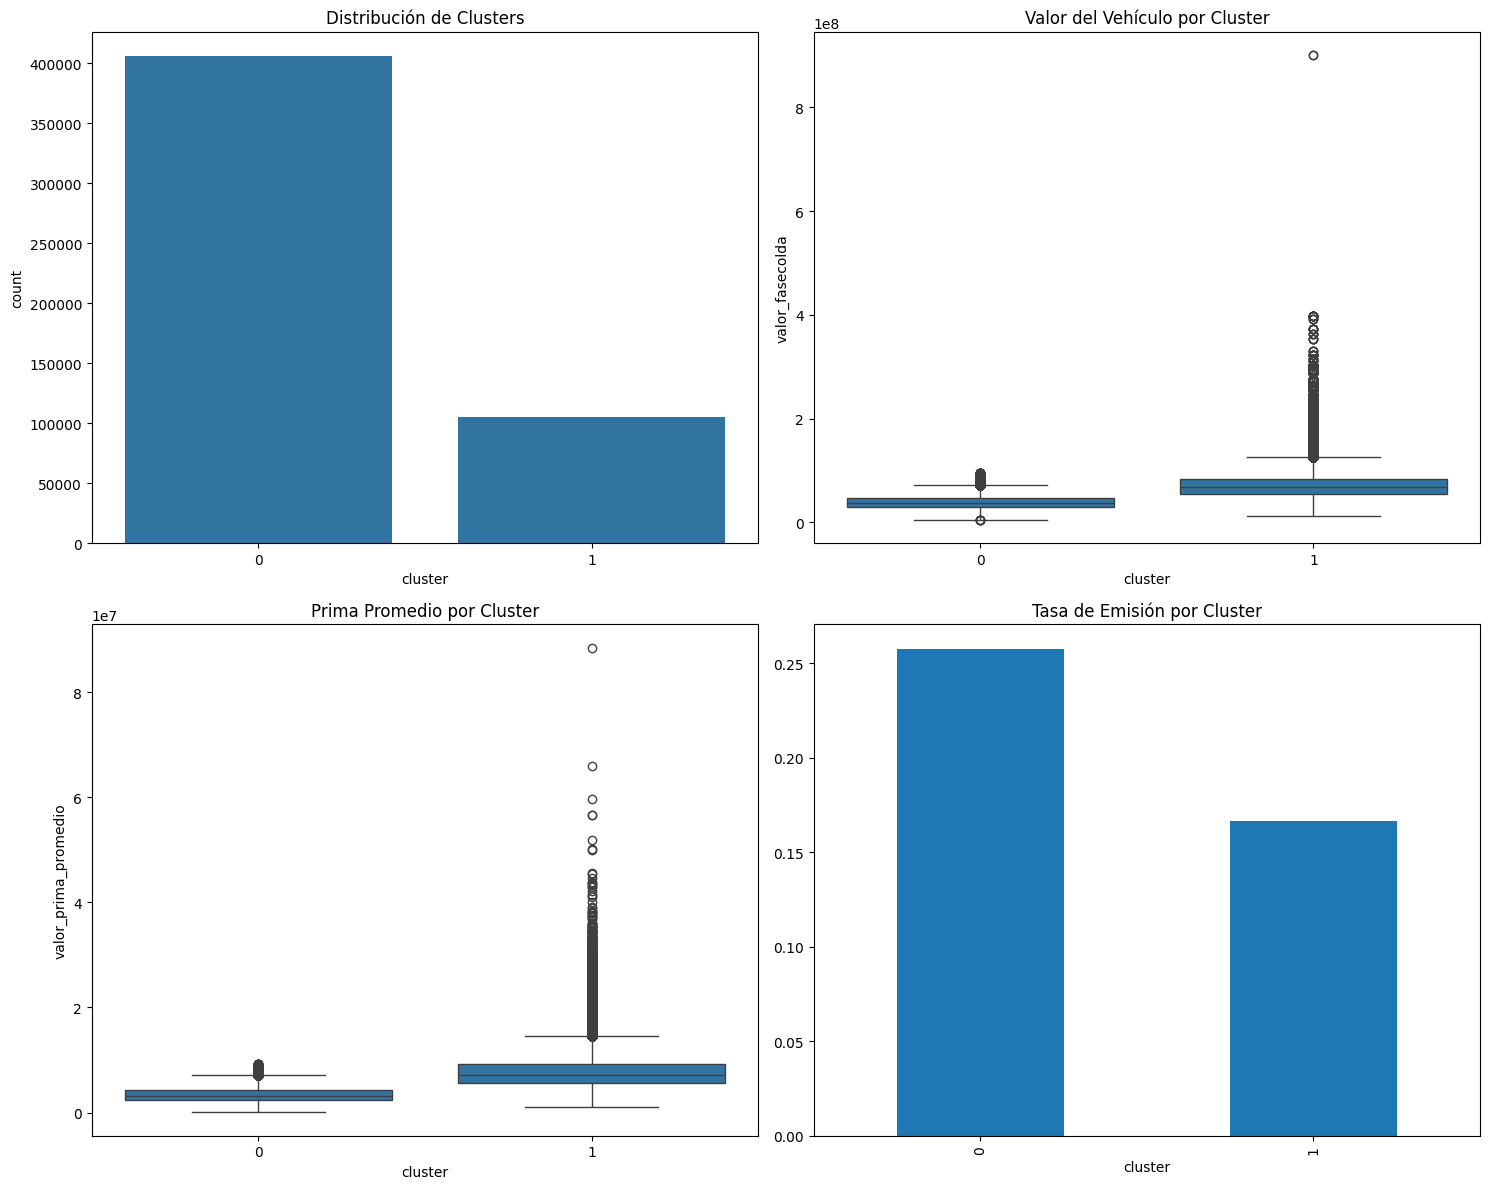

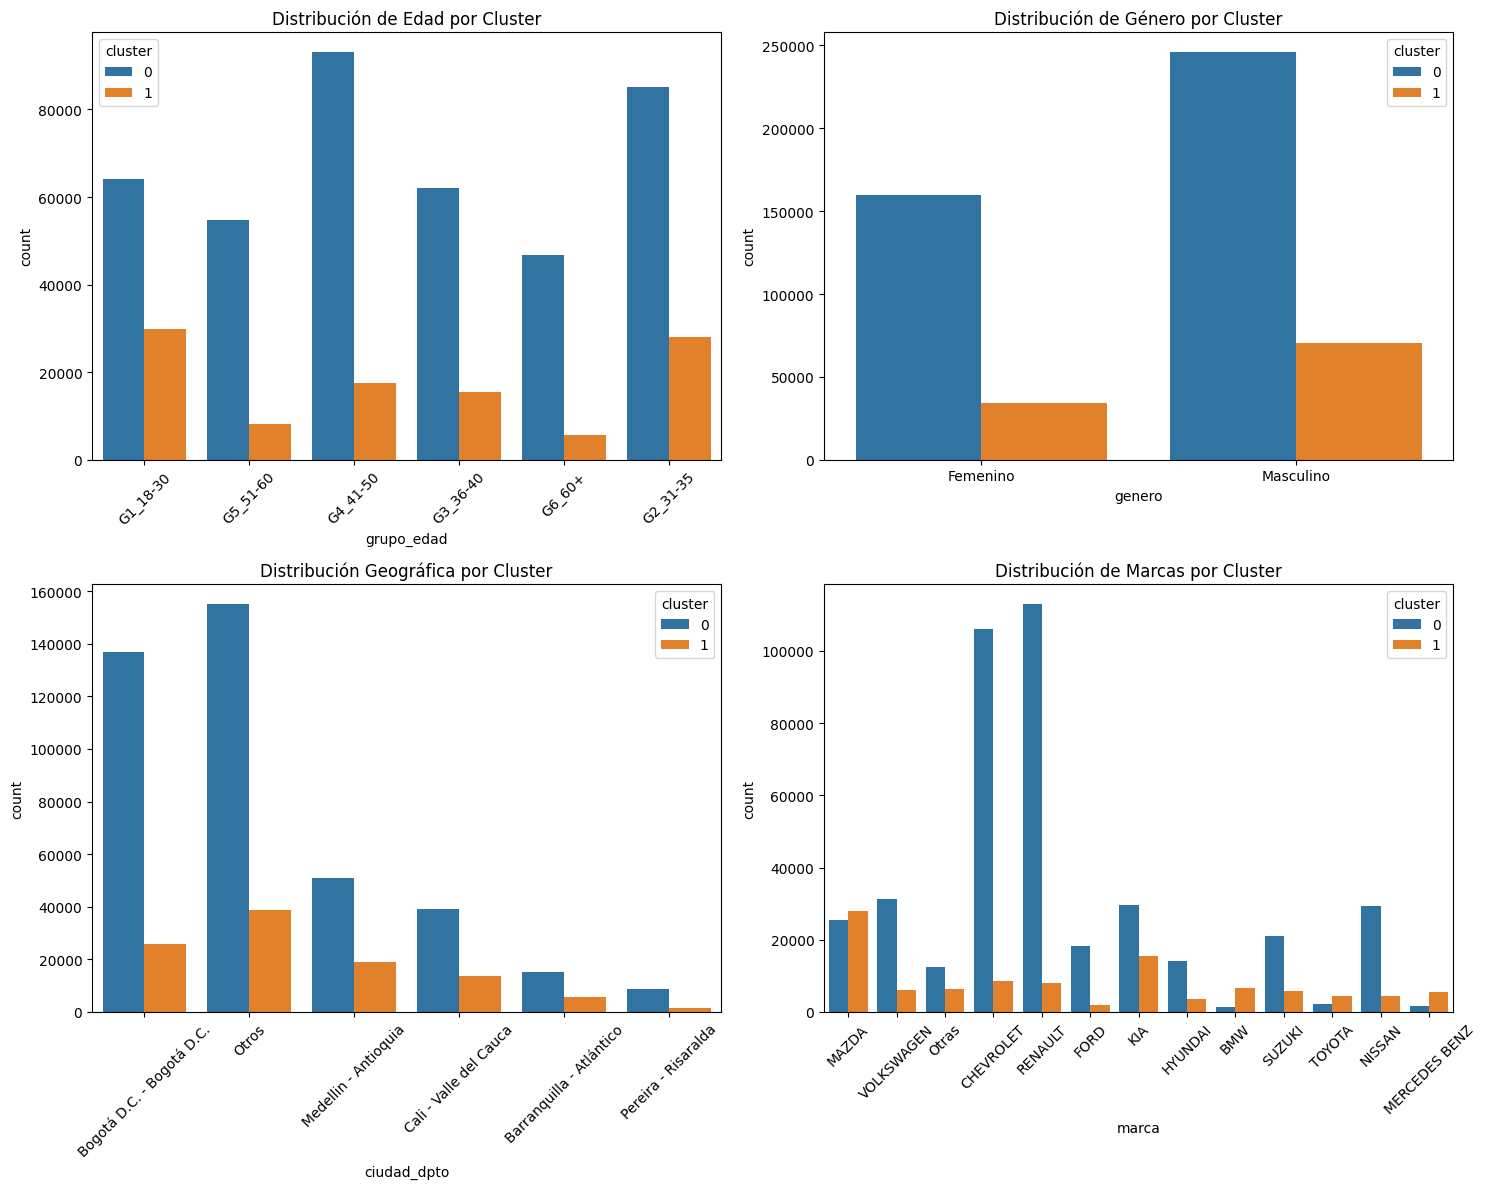

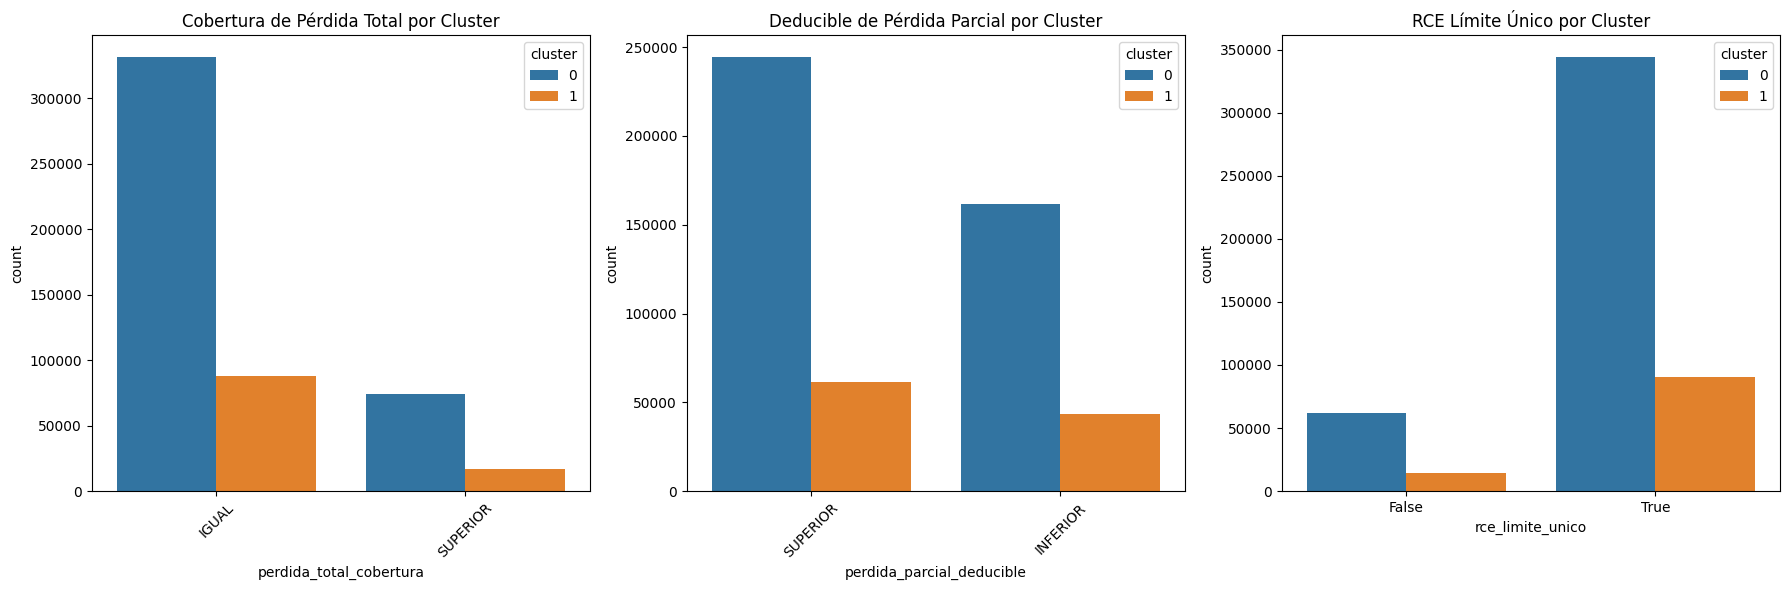


Resumen Estadístico por Cluster:
        valor_fasecolda              valor_prima_promedio             emitido
                   mean          std                 mean         std    mean
cluster                                                                      
0           39863237.89  12880737.43           3367057.33  1397647.41    0.26
1           73710531.33  32230449.47           7790248.77  3372474.00    0.17

CONCLUSIONES PRINCIPALES:
--------------------------------------------------

Cluster 1:
Características principales:
- Edad predominante: G1_18-30
- Género predominante: Masculino
- Ciudad principal: Otros
- Marca más común: MAZDA
- Valor promedio del vehículo: $73,710,531
- Prima promedio: $7,790,249
- Tasa de emisión: 16.65%

Productos más exitosos:
- Aseguradora5_TodoRiesgoMedio: 22.48% tasa de emisión
- Aseguradora12_Todo Riesgo Bajo: 22.31% tasa de emisión
- Aseguradora8_TodoRiesgoBajo: 22.26% tasa de emisión

Cluster 0:
Características principales:
- Edad predom

In [43]:
# Importar bibliotecas necesarias
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import numpy as np

# 1. Distribución general de clusters y métricas clave
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de clusters
sns.countplot(data=final_df, x='cluster', ax=axes[0,0])
axes[0,0].set_title('Distribución de Clusters')

# Valor promedio del vehículo por cluster
sns.boxplot(data=final_df, x='cluster', y='valor_fasecolda', ax=axes[0,1])
axes[0,1].set_title('Valor del Vehículo por Cluster')

# Prima promedio por cluster
sns.boxplot(data=final_df, x='cluster', y='valor_prima_promedio', ax=axes[1,0])
axes[1,0].set_title('Prima Promedio por Cluster')

# Tasa de emisión por cluster
emission_rates = final_df.groupby('cluster')['emitido'].mean()
emission_rates.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Tasa de Emisión por Cluster')

plt.tight_layout()
plt.show()

# 2. Análisis demográfico por cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de edad
sns.countplot(data=final_df, x='grupo_edad', hue='cluster', ax=axes[0,0])
axes[0,0].set_title('Distribución de Edad por Cluster')
axes[0,0].tick_params(axis='x', rotation=45)

# Distribución de género
sns.countplot(data=final_df, x='genero', hue='cluster', ax=axes[0,1])
axes[0,1].set_title('Distribución de Género por Cluster')

# Distribución de ciudad
sns.countplot(data=final_df, x='ciudad_dpto', hue='cluster', ax=axes[1,0])
axes[1,0].set_title('Distribución Geográfica por Cluster')
axes[1,0].tick_params(axis='x', rotation=45)

# Distribución de marca de vehículo
sns.countplot(data=final_df, x='marca', hue='cluster', ax=axes[1,1])
axes[1,1].set_title('Distribución de Marcas por Cluster')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Análisis de características del producto
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Distribución de cobertura de pérdida total
sns.countplot(data=final_df, x='perdida_total_cobertura', hue='cluster', ax=axes[0])
axes[0].set_title('Cobertura de Pérdida Total por Cluster')
axes[0].tick_params(axis='x', rotation=45)

# Distribución de deducible de pérdida parcial
sns.countplot(data=final_df, x='perdida_parcial_deducible', hue='cluster', ax=axes[1])
axes[1].set_title('Deducible de Pérdida Parcial por Cluster')
axes[1].tick_params(axis='x', rotation=45)

# Distribución de RCE límite único
sns.countplot(data=final_df, x='rce_limite_unico', hue='cluster', ax=axes[2])
axes[2].set_title('RCE Límite Único por Cluster')

plt.tight_layout()
plt.show()

# 4. Resumen estadístico por cluster
cluster_summary = final_df.groupby('cluster').agg({
    'valor_fasecolda': ['mean', 'std'],
    'valor_prima_promedio': ['mean', 'std'],
    'emitido': 'mean'
}).round(2)

print("\nResumen Estadístico por Cluster:")
print(cluster_summary)

# 5. Conclusiones textuales
print("\nCONCLUSIONES PRINCIPALES:")
print("-" * 50)

# Analizar perfiles de cluster
for cluster_id in final_df['cluster'].unique():
    cluster_data = final_df[final_df['cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id}:")
    print("Características principales:")
    
    # Características demográficas
    print(f"- Edad predominante: {cluster_data['grupo_edad'].mode()[0]}")
    print(f"- Género predominante: {cluster_data['genero'].mode()[0]}")
    print(f"- Ciudad principal: {cluster_data['ciudad_dpto'].mode()[0]}")
    
    # Características del vehículo
    print(f"- Marca más común: {cluster_data['marca'].mode()[0]}")
    print(f"- Valor promedio del vehículo: ${cluster_data['valor_fasecolda'].mean():,.0f}")
    
    # Características del producto
    print(f"- Prima promedio: ${cluster_data['valor_prima_promedio'].mean():,.0f}")
    print(f"- Tasa de emisión: {cluster_data['emitido'].mean():.2%}")
    
    # Productos más exitosos
    top_products = cluster_data.groupby('aseguradora_producto')['emitido'].mean().sort_values(ascending=False).head(3)
    print("\nProductos más exitosos:")
    for prod, rate in top_products.items():
        print(f"- {prod}: {rate:.2%} tasa de emisión")